In [1]:
# I noticed on some of Ian's images that the lattice wasn't being completely masked.
# I suspect the reason is the search is missing those points because we aren't extending the grid to cover
# The whole image.

# OR

# The problem could be that I am not completely masking a point.

In [2]:
# I need a way to look at the power spectrum of an image after subtraction. Let's pick an example and take
# it to that point.

# Copy/paste some parameters from mask_pbsapo_micrographs.ipynb

In [1]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdsec_opened
from itertools import product

In [2]:
from PIL import Image

In [3]:
threshold_method='sd' 
pixel_size = 1.048
verbose=True
show_plots=True
threads=16
sigma=15 
num_sd=3
num_sd_secondpass=2.5
x_window_percent=(0, 0.7)
y_window_percent=(0, 0.995)
miller_index_buffer=10
box_radius=10
min_lattice_size=8
epsilon=0.33
mask_hotpixels=False
mask_radius=6
replace_distance_percent=0.075
return_spots=False
return_stats=False
return_image=False

In [4]:
filename = 'test_data/test_lattice.mrc'
filename_out = 'test_data/test_lattice_masked.mrc'

scipy_fft(): FFT performed in 144.03 milliseconds.
Number of first-pass spots found: 92


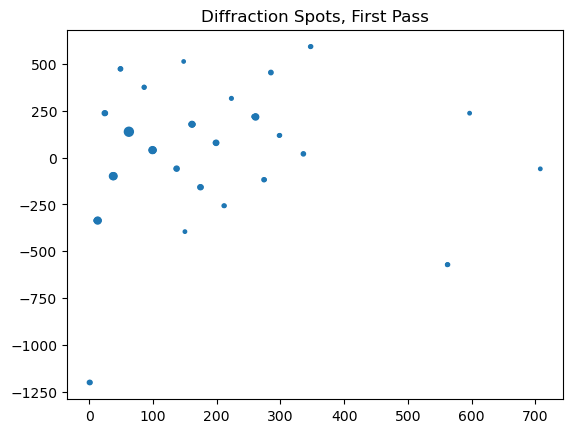

Starting basis: [[138 -99]
 [ 62  37]]
Starting basis size: 34058
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 135.31419624284092
[138  62] is larger than [-99  37]
The updated basis vectors are [39 99][-99  37]
This run resulted in a basis smaller than the last: 22492
The updated basis vectors are: [[ 39 -99]
 [ 99  37]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


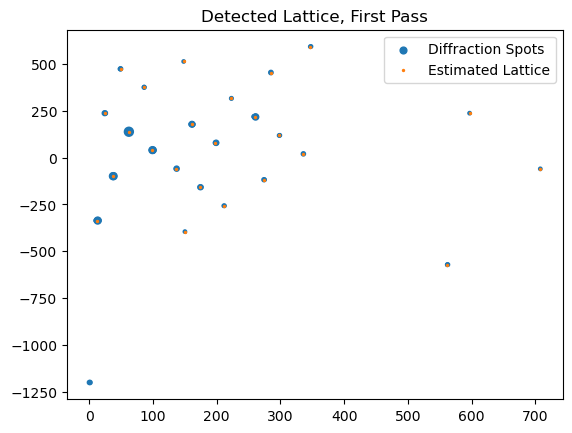

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.45270565 -98.70326539]
 [ 99.37867465  37.49838621]]
Unit cell dimensions (A): 56.46 57.17
Highest resolution spot (A): 7.53


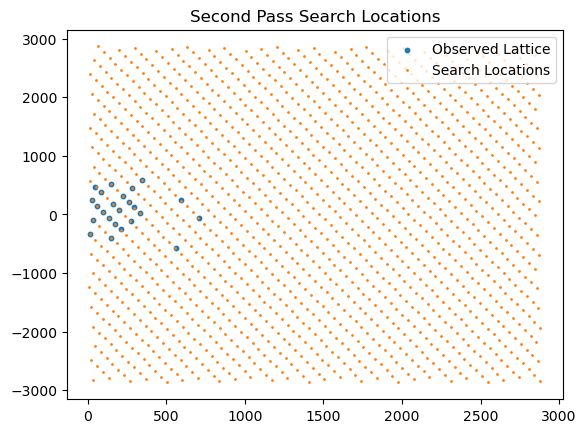

No new points found on second pass. Returning first pass lattice.


In [16]:
# Import the image
image, header = sax.import_mrc(filename)

# Perform an FFT of the image
padded_fft = sax.scipy_fft(image, verbose, threads)

# Subtract the FFT from a Gaussian-smoothed FFT
log_diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

# Find diffraction spots
if threshold_method == "quantile":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_quantile(log_diff_spectrum, quantile, x_window_percent, y_window_percent)
if threshold_method == "sd":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, num_sd, x_window_percent, y_window_percent)

# Return some info if function is verbose
if verbose:
    print("Number of first-pass spots found: " + str(diffraction_indices.shape[1]))


# Look for the first lattice
combined_nonredundant_lattice, unit_cell_dimensions, highest_resolution = sax.find_lattice(diffraction_indices, 
                                                                                       diffraction_amplitudes, 
                                                                                       log_diff_spectrum,
                                                                                       pixel_size,
                                                                                       show_plots=show_plots,
                                                                                       verbose=verbose, 
                                                                                       num_sd_secondpass=num_sd_secondpass, 
                                                                                       miller_index_buffer=miller_index_buffer,
                                                                                       box_radius=box_radius,
                                                                                       min_lattice_size=min_lattice_size,
                                                                                       epsilon=epsilon)

# Store the results in arrays
unit_cell_dimensions_array = np.array(unit_cell_dimensions)
highest_resolution_array = np.array([highest_resolution])

# Generate the mask indices
mask_indices_array = sax.generate_lattice_mask_indices(combined_nonredundant_lattice, mask_radius)

In [17]:
# Generate a masked fft
masked_fft = np.copy(padded_fft)

# Generate a vector of random phases with the same length as number of diffraction_spots
phases = np.random.uniform(low = 0.0,
                           high = 2*np.pi,
                           size = wrapped_diffraction_indices.shape[0])
phase_count = 0

# Figure out the movement distances horizontally and vertically
replace_distance = int((np.min(padded_fft.shape)*replace_distance_percent)/np.sqrt(2))

In [36]:
# Construct rotation matrices for 20 degree rotation
rad = (20/180)*np.pi

rot_c = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])
rot_cc = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])

In [45]:
# This entire thing can be rewritten to have just one conditional statement: apply rot_c or rot_cc

phase_count = 0
for indices in mask_indices_array:
        # If we're in the top quadrant
        if indices[0] >= 0:
            print(indices)
            # Rotate the indices 20 degrees clockwise
            rot_indices = np.matmul(rot_c, np.array([indices[1], indices[0]])).astype(int)
            rot_indices = np.array([rot_indices[1], rot_indices[0]])
            print(rot_indices)
            # Construct the replacement by pulling the value from
            # the rotated indices
            real = smoothed_spectrum[rot_indices[0], rot_indices[1]]
            imaginary = phases[phase_count]
            replacement = real + np.imag(imaginary)
            
            #
            
            
            masked_fft[int(indices[0]), int(indices[1])] = replacement
        # If we're in the bottom quadrant
        else:
            print(indices)
            # Rotate the indices 20 degrees clockwise
            rot_indices = np.matmul(rot_cc, np.array([indices[1], indices[0]])).astype(int)
            rot_indices = np.array([rot_indices[1], rot_indices[0]])
            print(rot_indices)
            # Construct the replacement by pulling the value from
            # the rotated indices
            real = smoothed_spectrum[rot_indices[0], rot_indices[1]]
            imaginary = phases[phase_count]
            replacement = real + np.imag(imaginary)
            masked_fft[int(indices[0]), int(indices[1])] = replacement
            
            # Replace
            #masked_fft[int(indices[0]), int(indices[1])] = replacement
        # Increment the phase count
        phase_count += 1
        print(phase_count)

[-342.    6.]
[-319  122]
1
[-342.    7.]
[-318  123]
2
[-342.    8.]
[-318  124]
3
[-342.    9.]
[-318  125]
4
[-342.   10.]
[-317  126]
5
[-342.   11.]
[-317  127]
6
[-342.   12.]
[-317  128]
7
[-342.   13.]
[-316  129]
8
[-342.   14.]
[-316  130]
9
[-342.   15.]
[-316  131]
10
[-342.   16.]
[-315  132]
11
[-342.   17.]
[-315  132]
12
[-342.   18.]
[-315  133]
13
[-341.    6.]
[-318  122]
14
[-341.    7.]
[-318  123]
15
[-341.    8.]
[-317  124]
16
[-341.    9.]
[-317  125]
17
[-341.   10.]
[-317  126]
18
[-341.   11.]
[-316  126]
19
[-341.   12.]
[-316  127]
20
[-341.   13.]
[-315  128]
21
[-341.   14.]
[-315  129]
22
[-341.   15.]
[-315  130]
23
[-341.   16.]
[-314  131]
24
[-341.   17.]
[-314  132]
25
[-341.   18.]
[-314  133]
26
[-340.    6.]
[-317  121]
27
[-340.    7.]
[-317  122]
28
[-340.    8.]
[-316  123]
29
[-340.    9.]
[-316  124]
30
[-340.   10.]
[-316  125]
31
[-340.   11.]
[-315  126]
32
[-340.   12.]
[-315  127]
33
[-340.   13.]
[-315  128]
34
[-340.   14.]
[-314  12

scipy_fft(): FFT performed in 156.3 milliseconds.
Number of first-pass spots found: 92


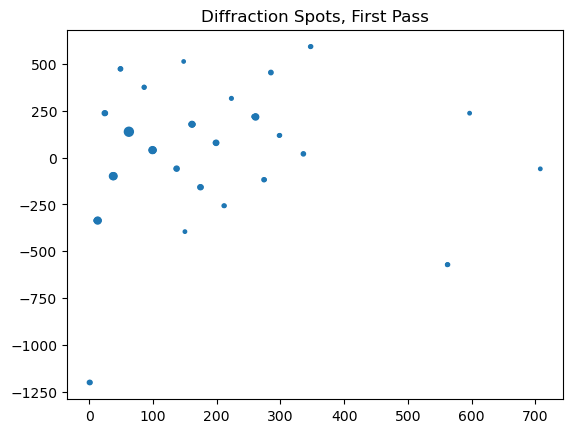

Starting basis: [[138 -99]
 [ 62  37]]
Starting basis size: 34058
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 135.31419624284092
[138  62] is larger than [-99  37]
The updated basis vectors are [39 99][-99  37]
This run resulted in a basis smaller than the last: 22492
The updated basis vectors are: [[ 39 -99]
 [ 99  37]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


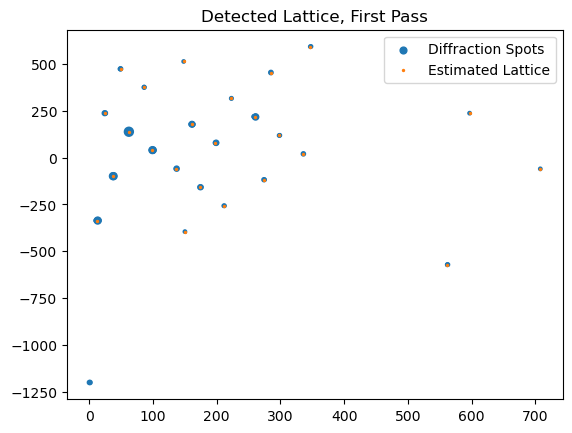

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.45270565 -98.70326539]
 [ 99.37867465  37.49838621]]
Unit cell dimensions (A): 56.46 57.17
Highest resolution spot (A): 7.53


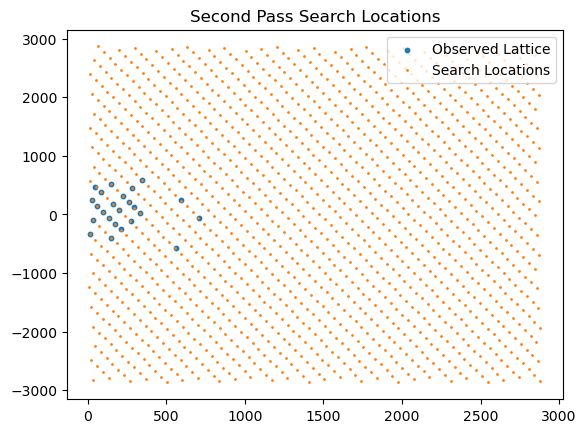

/home/rk/anaconda3/envs/saxtal/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rk/anaconda3/envs/saxtal/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/rk/anaconda3/envs/saxtal/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rk/anaconda3/envs/saxtal/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rk/anaconda3/envs/saxtal/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


No new points found on second pass. Returning first pass lattice.


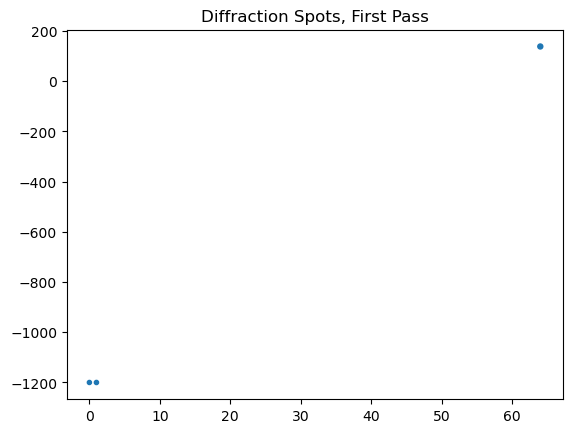

Lattice has less than 8 candidate basis vectors during first pass. Terminating function.
scipy_ifft(): iFFT performed in 131.34 milliseconds.
Export complete!
test_data/test_lattice.mrc masked successfully!


In [6]:
sax.mask_image(filename,
               filename_out,
               threshold_method = threshold_method,
               pixel_size = pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_radius= mask_radius,
               replace_distance_percent = replace_distance_percent,
               epsilon = epsilon,
               return_spots = False,
               return_stats = False,
               return_fft = False,
               return_image = False)

scipy_fft(): FFT performed in 146.98 milliseconds.
Number of first-pass spots found: 92


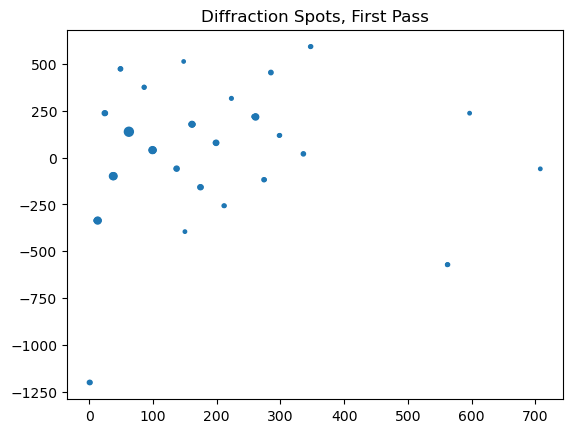

Starting basis: [[138 -99]
 [ 62  37]]
Starting basis size: 34058
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 135.31419624284092
[138  62] is larger than [-99  37]
The updated basis vectors are [39 99][-99  37]
This run resulted in a basis smaller than the last: 22492
The updated basis vectors are: [[ 39 -99]
 [ 99  37]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


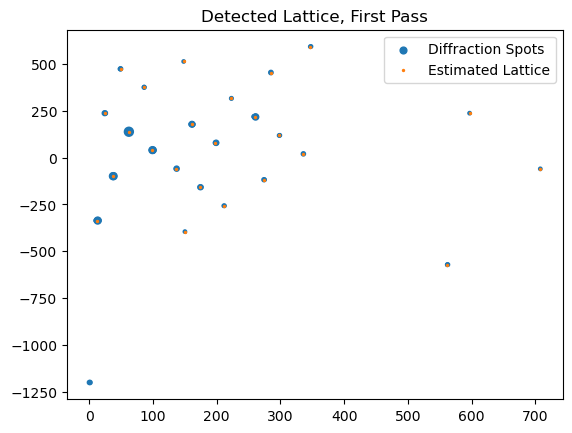

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.45270565 -98.70326539]
 [ 99.37867465  37.49838621]]
Unit cell dimensions (A): 56.46 57.17
Highest resolution spot (A): 7.53


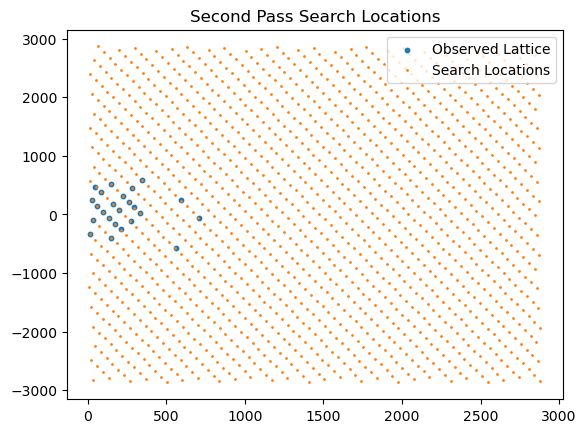

No new points found on second pass. Returning first pass lattice.


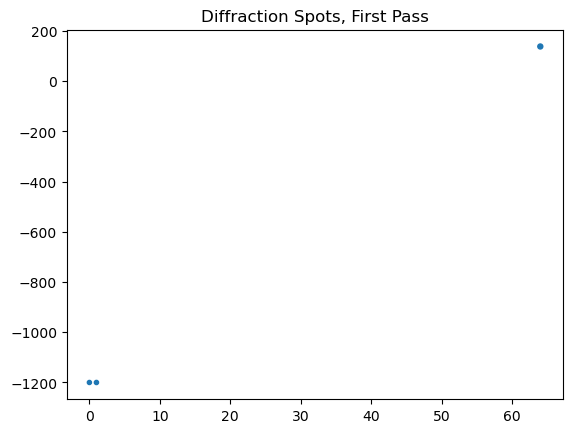

Lattice has less than 8 candidate basis vectors during first pass. Terminating function.


In [11]:
masked_fft = sax.mask_image(filename,
               filename_out,
               threshold_method = threshold_method,
               pixel_size = pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_radius= mask_radius,
               replace_distance_percent = replace_distance_percent,
               epsilon = epsilon,
               return_spots = False,
               return_stats = False,
               return_fft = True,
               return_image = False)

<Figure size 6000x6000 with 0 Axes>

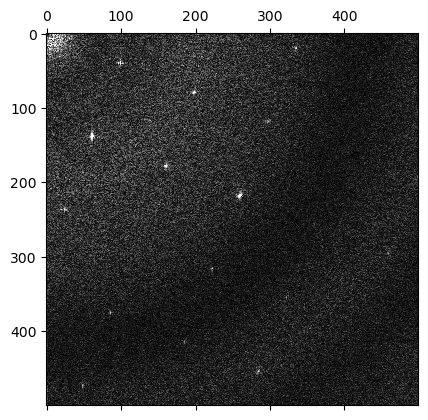

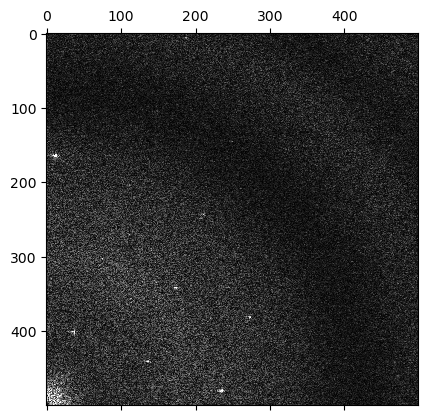

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=300)
# Display the unmasked power spectrum



plt.matshow(np.abs(padded_fft)[:500, :500],
           cmap = "Greys_r",
           vmax = 4000,
           vmin = 0)

plt.matshow(np.abs(padded_fft)[-500:, :500],
           cmap = "Greys_r",
           vmax = 4000,
           vmin = 0)

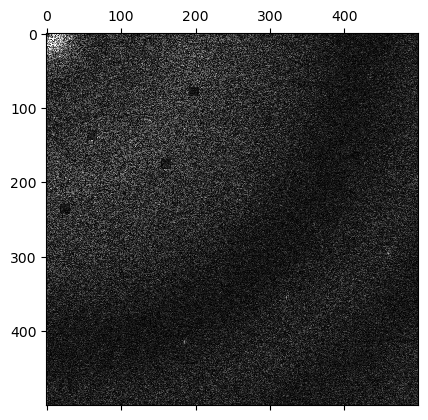

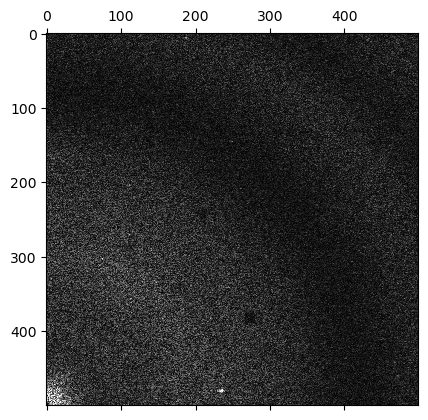

In [12]:
# Display the masked power spectrum

plt.matshow(np.abs(masked_fft)[:500, :500],
           cmap = "Greys_r",
           vmax = 4000,
           vmin = 0)

plt.matshow(np.abs(masked_fft)[-500:, :500],
           cmap = "Greys_r",
           vmax = 4000,
           vmin = 0)